In [32]:
%matplotlib inline
%reload_ext autoreload
%autoreload 

In [33]:
from torchvision.models import *

from fastai.vision import *
from fastai.vision.models import *
from fastai.vision.learner import model_meta

from utilities import *
import sys

In [34]:
import pandas as pd
import numpy as np

In [35]:
import warnings
warnings.filterwarnings("ignore")

## Read Dataset Files

In [36]:
DATASET_BASE = "/floyd/input/raw_deepfashion_dataset/raw_deepfashion_dataset" 

In [37]:
list_eval_partition = os.path.join(DATASET_BASE, r'Eval', r'list_eval_partition.txt')
list_category_img = os.path.join(DATASET_BASE, r'Anno', r'list_category_img.txt')
list_category_cloth = os.path.join(DATASET_BASE, r'Anno', r'list_category_cloth.txt')

In [38]:
# get_category_names
with open(list_category_cloth, 'r') as f:
    categories = []
    for i, line in enumerate(f.readlines()):
        if i > 1:
            categories.append(line.split(' ')[0])

In [39]:
# get image category map
with open(list_category_img, 'r') as f:
    images = []
    for i, line in enumerate(f.readlines()):
        if i > 1:
            images.append([word.strip() for word in line.split(' ') if len(word) > 0])

In [40]:
#get train, valid, test split
with open(list_eval_partition, 'r') as f:
    images_partition = []
    for i, line in enumerate(f.readlines()):
        if i > 1:
            images_partition.append([word.strip() for word in line.split(' ') if len(word) > 0])

In [41]:
data_df = pd.DataFrame(images, columns=['images', 'category_label'])
partition_df = pd.DataFrame(images_partition, columns=['images', 'dataset'])

In [42]:
data_df['category_label'] = data_df['category_label'].astype(int)

In [43]:
data_df = data_df.merge(partition_df, on='images')

In [44]:
data_df['dataset'].value_counts()

train    209222
val       40000
test      40000
Name: dataset, dtype: int64

In [45]:
data_df['category'] = data_df['category_label'].apply(lambda x: categories[int(x) - 1])

In [46]:
data_df['category_label'].nunique()

46

In [47]:
data_df.head()

,images,category_label,dataset,category
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,3,train,Blouse
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,3,train,Blouse
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,3,val,Blouse
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,3,train,Blouse
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,3,test,Blouse


In [48]:
# Use only the upper wear to save time`

In [49]:
data_df = data_df.query('category_label <= 20')

In [50]:
data_df['dataset'].value_counts()

train    100983
test      19409
val       19317
Name: dataset, dtype: int64

## Prepare DataBunch

In [51]:
from pathlib import Path

In [52]:
data_source = (ImageList.from_df(df=data_df, path=DATASET_BASE, cols='images')
                    .split_by_idxs((data_df[data_df['dataset']=='train'].index), (data_df[data_df['dataset']=='val'].index))
                    .label_from_df(cols='category')
              )

In [53]:
tmfs = get_transforms()
data = data_source.transform(tmfs, size=224).databunch(bs=128).normalize(imagenet_stats)

In [54]:
test_data = ImageList.from_df(df=data_df[data_df['dataset'] == 'test'], path=DATASET_BASE, cols='images')
data.add_test(test_data)

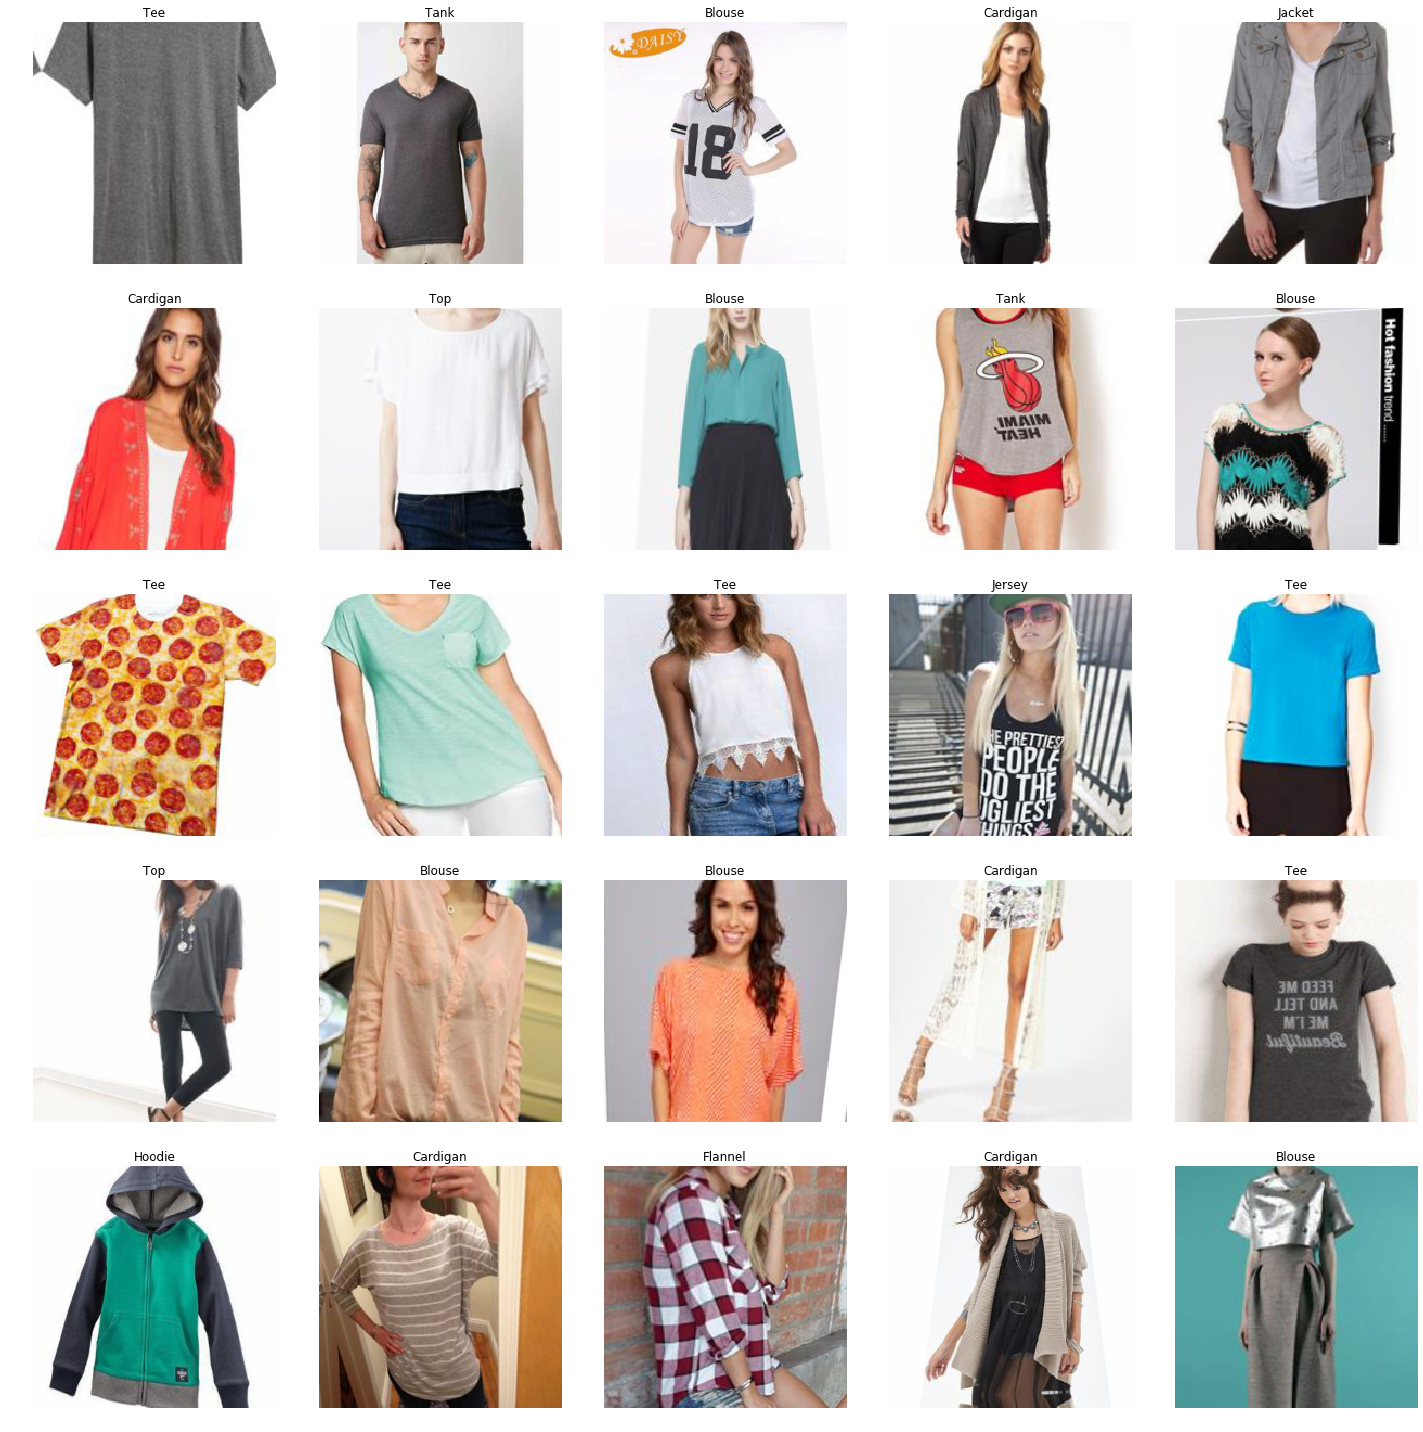

In [55]:
data.show_batch()

In [56]:
data

ImageDataBunch;

Train: LabelList (100983 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Blouse,Blouse,Blouse,Blouse,Blouse
Path: /floyd/input/raw_deepfashion_dataset/raw_deepfashion_dataset;

Valid: LabelList (19317 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Blouse,Blouse,Blouse,Blouse,Blouse
Path: /floyd/input/raw_deepfashion_dataset/raw_deepfashion_dataset;

Test: LabelList (19409 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /floyd/input/raw_deepfashion_dataset/raw_deepfashion_dataset

## ResNet34 Model

In [26]:
arch_summary(resnet34)

(0) Conv2d      : 1   layers (total: 1)
(1) BatchNorm2d : 1   layers (total: 2)
(2) ReLU        : 1   layers (total: 3)
(3) MaxPool2d   : 1   layers (total: 4)
(4) Sequential  : 15  layers (total: 19)
(5) Sequential  : 22  layers (total: 41)
(6) Sequential  : 32  layers (total: 73)
(7) Sequential  : 17  layers (total: 90)
(8) AvgPool2d   : 1   layers (total: 91)
(9) Linear      : 1   layers (total: 92)


In [27]:
from fastai.metrics import accuracy, top_k_accuracy

top_3_accuracy = partial(top_k_accuracy, k=3)
top_5_accuracy = partial(top_k_accuracy, k=5)

In [28]:
learner = cnn_learner(data, models.resnet34, path='output', metrics=[accuracy, top_3_accuracy, top_5_accuracy])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:01, 85764231.55it/s]


In [30]:
learner.model = torch.nn.DataParallel(learner.model)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


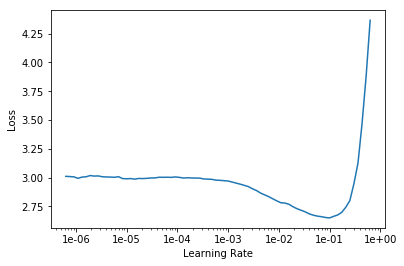

In [31]:
learner.lr_find()
learner.recorder.plot()

In [32]:
learner.fit_one_cycle(10, max_lr=5e-03)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,top_k_accuracy,time
0,1.467101,1.372385,0.556194,0.827820,0.925972,12:31
1,1.407579,1.357750,0.561060,0.833825,0.926438,11:59
2,1.395352,1.331569,0.567221,0.838588,0.931718,11:54
3,1.355855,1.333438,0.567428,0.838743,0.932495,11:53
4,1.320825,1.326782,0.568618,0.837138,0.931718,11:58
5,1.295651,1.255644,0.591914,0.853549,0.939225,11:58
6,1.274343,1.229627,0.605166,0.860744,0.941451,11:50
7,1.256484,1.209530,0.610757,0.866387,0.944712,11:57
8,1.197151,1.200311,0.615054,0.866284,0.944712,11:54
9,1.211562,1.198677,0.616089,0.866957,0.945126,11:56


In [33]:
learner.save('resnet34_final')

## ResNet50 pretrained model

In [57]:
arch_summary(resnet50)

(0) Conv2d      : 1   layers (total: 1)
(1) BatchNorm2d : 1   layers (total: 2)
(2) ReLU        : 1   layers (total: 3)
(3) MaxPool2d   : 1   layers (total: 4)
(4) Sequential  : 23  layers (total: 27)
(5) Sequential  : 30  layers (total: 57)
(6) Sequential  : 44  layers (total: 101)
(7) Sequential  : 23  layers (total: 124)
(8) AvgPool2d   : 1   layers (total: 125)
(9) Linear      : 1   layers (total: 126)


In [58]:
from fastai.metrics import accuracy, top_k_accuracy

top_3_accuracy = partial(top_k_accuracy, k=3)
top_5_accuracy = partial(top_k_accuracy, k=5)

In [59]:
learner = cnn_learner(data, models.resnet50, path='output', metrics=[accuracy, top_3_accuracy, top_5_accuracy])

In [60]:
learner.model = torch.nn.DataParallel(learner.model)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


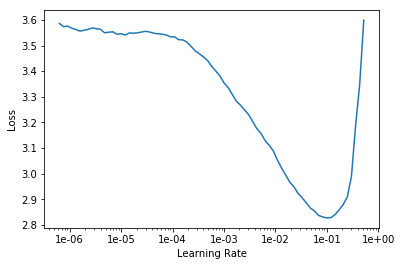

In [62]:
learner.lr_find()
learner.recorder.plot()

In [56]:
learner.fit_one_cycle(10, max_lr=1e-03)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,top_k_accuracy,time
0,1.693878,1.480867,0.549568,0.817674,0.912616,27:56
1,1.349565,1.277016,0.588963,0.849200,0.938655,27:42
2,1.288646,1.227312,0.607548,0.862453,0.941968,27:40
3,1.260600,1.209440,0.610913,0.862970,0.944867,27:38
4,1.236127,1.188848,0.621214,0.867992,0.946110,27:38
5,1.187463,1.168302,0.627064,0.873531,0.948232,27:34
6,1.181978,1.153480,0.632500,0.876275,0.950406,27:35
7,1.153823,1.145291,0.635451,0.877828,0.951338,27:35
8,1.135972,1.141277,0.637677,0.878449,0.951183,27:44
9,1.112883,1.141465,0.637211,0.877207,0.950821,27:44


In [57]:
learner.save('resnet50_final')

In [32]:
# .module because DataParallel was used
model = learner.model.module

## Get image feature vectors

In [33]:
class Hook():
    "Create a hook on `m` with `hook_func`."
    def __init__(self, m:nn.Module, hook_func:HookFunc, is_forward:bool=True, detach:bool=True):
        self.hook_func,self.detach,self.stored = hook_func,detach,None
        f = m.register_forward_hook if is_forward else m.register_backward_hook
        self.hook = f(self.hook_fn)
        self.removed = False

    def hook_fn(self, module:nn.Module, input:Tensors, output:Tensors):
        "Applies `hook_func` to `module`, `input`, `output`."
        if self.detach:
            input  = (o.detach() for o in input ) if is_listy(input ) else input.detach()
            output = (o.detach() for o in output) if is_listy(output) else output.detach()
        self.stored = self.hook_func(module, input, output)

    def remove(self):
        "Remove the hook from the model."
        if not self.removed:
            self.hook.remove()
            self.removed=True

    def __enter__(self, *args): return self
    def __exit__(self, *args): self.remove()
        
def get_output(module, input_value, output):
    return output.flatten(1)

def get_input(module, input_value, output):
    return list(input_value)[0]

def get_named_module_from_model(model, name):
    for n, m in model.named_modules():
        if n == name:
            return m
    return None

In [34]:
linear_output_layer = get_named_module_from_model(model, '1.4')
linear_output_layer

Linear(in_features=4096, out_features=512, bias=True)

In [36]:
# getting all images in train
train_valid_images_df = data_df[data_df['dataset'] != 'test']
inference_data_source = (ImageList.from_df(df=train_valid_images_df, path=DATASET_BASE, cols='images')
                    .split_none()
                    .label_from_df(cols='category')
              )

In [37]:
inference_data = inference_data_source.transform(tmfs, size=224).databunch(bs=32).normalize(imagenet_stats)

In [38]:
inference_dataloader = inference_data.train_dl.new(shuffle=False)

In [39]:
import time
img_repr_map = {}

with Hook(linear_output_layer, get_output, True, True) as hook:
    start = time.time()
    for i, (xb, yb) in enumerate(inference_dataloader):
        bs = xb.shape[0]
        img_ids = inference_dataloader.items[i*bs: (i+1)*bs]
        result = model.eval()(xb)
        img_reprs = hook.stored.cpu().numpy()
        img_reprs = img_reprs.reshape(bs, -1)
        for img_id, img_repr in zip(img_ids, img_reprs):
            img_repr_map[img_id] = img_repr
        if(len(img_repr_map) % 12800 == 0):
            end = time.time()
            print(f'{end-start} secs for 12800 images')
            start = end

95.57137036323547 secs for 12800 images
91.8145763874054 secs for 12800 images
91.67074728012085 secs for 12800 images
91.66322088241577 secs for 12800 images
91.68284606933594 secs for 12800 images
91.77868866920471 secs for 12800 images
91.8419120311737 secs for 12800 images
91.92586731910706 secs for 12800 images
91.88006281852722 secs for 12800 images


In [116]:
len(list(img_repr_map.keys()))

120288

In [63]:
deep_feats = []
labels = []

In [77]:
feat_all = 'output/all_feat.npy'
feat_list = 'output/all_feat.list'

In [71]:
deep_feats = list(img_repr_map.values())

In [70]:
labels = list(img_repr_map.keys())

In [78]:
np.save(feat_all, np.vstack(deep_feats))

In [79]:
with open(feat_list, "w") as fw:
    fw.write("\n".join(labels))

In [117]:
deep_feats = np.load(feat_all)

In [119]:
deep_feats[0:5]

array([[ 1.471948, 17.086193,  0.      ,  3.527837, ...,  0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  4.253828,  0.      ,  0.      , ...,  0.      ,  0.133641,  4.407089,  0.      ],
       [ 1.500832,  8.732462,  7.653079,  0.      , ...,  3.752906,  0.      ,  8.938953,  0.      ],
       [ 0.      , 14.321926,  0.      ,  1.713061, ...,  0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  9.950463,  9.03424 ,  3.296867, ...,  1.6291  ,  0.      ,  8.335487,  0.37026 ]], dtype=float32)